In [414]:
import pandas as pd
import numpy as np
import sklearn as sk

In [415]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [416]:
sales_df = pd.read_excel('Amazon_Customer_Purchase_Data.xlsx')

In [417]:
sales_df.describe()

,Customer_ID,Age,Product_ID,Purchase_Date,Purchase_Amount,Rating,Customer_Lifetime_Value,Loyalty_Score
count,2000.000000,1900.000000,2000.000000,2000,1800.000000,1860.000000,1800.000000,2000.00000
mean,15022.171500,43.696316,546.669000,2020-02-11 15:29:59.999999744,257.954370,2.978495,2566.724026,51.45700
min,10001.000000,18.000000,100.000000,2020-01-01 00:00:00,10.077295,1.000000,56.153142,1.00000
25%,12585.750000,31.000000,320.750000,2020-01-21 19:45:00,134.525844,2.000000,1218.808126,26.00000
50%,15104.500000,43.000000,551.000000,2020-02-11 15:30:00,257.545509,3.000000,2305.364380,52.00000
75%,17408.250000,57.000000,763.000000,2020-03-03 11:15:00,383.819725,4.000000,3651.162484,76.00000
max,19998.000000,69.000000,998.000000,2020-03-24 07:00:00,499.839871,5.000000,7204.408434,100.00000
std,2865.577794,14.902947,259.999847,NaN,142.217621,1.409478,1652.968815,28.74591


In [418]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer_ID                 2000 non-null   int64         
 1   Customer_Name               1900 non-null   object        
 2   Age                         1900 non-null   float64       
 3   Gender                      2000 non-null   object        
 4   Location                    2000 non-null   object        
 5   Product_Category            2000 non-null   object        
 6   Product_ID                  2000 non-null   int64         
 7   Purchase_Date               2000 non-null   datetime64[ns]
 8   Purchase_Amount             1800 non-null   float64       
 9   Payment_Method              2000 non-null   object        
 10  Rating                      1860 non-null   float64       
 11  Feedback_Comments           1099 non-null   object      

In [419]:
#Step 1: Data cleaning & pre-processing

In [420]:
## A. Handling Missing Values
## As can be seen above, amongst the numerical columns, the following have missing values: Age - 100, Purchase_Amount-1800, Rating - 140 , Customer_Lifetime_Value-200
# Amongst the non-numerical columns, the following have missing values: Customer_Name-100, Feedback comments- 901
#However for the purposes of further analyses and model building, the important ones to fill out are Age, Purchase_Amount, Rating and Customer_Lifestime_Value.

In [421]:
# Filling missing values in Age- best to fill with mean here
from sklearn.impute import SimpleImputer
age_imputer = SimpleImputer(strategy='mean')
sales_df['Age'] = age_imputer.fit_transform(sales_df[['Age']])
sales_df['Age'] = sales_df['Age'].round().astype(int)



In [422]:
# Filling missing values in Rating- best to fill with mode here
rating_imputer = SimpleImputer(strategy='mode')
sales_df['Rating'] = age_imputer.fit_transform(sales_df[['Rating']])
sales_df['Rating'] = sales_df['Rating'].round().astype(int)



In [423]:
# Filling missing values in Purchase Amount- best to fill with mean price per product
product_price_mean = (sales_df.groupby('Product_ID')['Purchase_Amount'].mean())
sales_df['Purchase_Amount'] = sales_df['Purchase_Amount'].fillna(sales_df['Product_ID'].map(product_price_mean))
sales_df['Purchase_Amount'].fillna(sales_df['Purchase_Amount'].mean(), inplace=True) # Fallback in case purchase amount is empty where product ID price is mean


/tmp/ipython-input-351768449.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sales_df['Purchase_Amount'].fillna(sales_df['Purchase_Amount'].mean(), inplace=True) # Fallback in case purchase amount is empty where product ID price is mean


In [424]:
sales_df.describe()

,Customer_ID,Age,Product_ID,Purchase_Date,Purchase_Amount,Rating,Customer_Lifetime_Value,Loyalty_Score
count,2000.000000,2000.000000,2000.000000,2000,2000.000000,2000.000000,1800.000000,2000.00000
mean,15022.171500,43.711500,546.669000,2020-02-11 15:29:59.999999744,258.276910,2.980000,2566.724026,51.45700
min,10001.000000,18.000000,100.000000,2020-01-01 00:00:00,10.077295,1.000000,56.153142,1.00000
25%,12585.750000,32.000000,320.750000,2020-01-21 19:45:00,144.316682,2.000000,1218.808126,26.00000
50%,15104.500000,44.000000,551.000000,2020-02-11 15:30:00,258.276910,3.000000,2305.364380,52.00000
75%,17408.250000,56.000000,763.000000,2020-03-03 11:15:00,379.609812,4.000000,3651.162484,76.00000
max,19998.000000,69.000000,998.000000,2020-03-24 07:00:00,499.839871,5.000000,7204.408434,100.00000
std,2865.577794,14.525556,259.999847,NaN,138.144753,1.359236,1652.968815,28.74591


In [425]:
## B. Removing duplicates
duplicate_rows = sales_df[sales_df.duplicated(subset=['Customer_ID', 'Purchase_Date'], keep=False)]

duplicate_rows.sort_values(by=['Customer_ID', 'Purchase_Date']).head(10)


,Customer_ID,Customer_Name,Age,Gender,Location,Product_Category,Product_ID,Purchase_Date,Purchase_Amount,Payment_Method,Rating,Feedback_Comments,Customer_Lifetime_Value,Loyalty_Score,Discount_Applied,Return_Status,Customer_Segment,Preferred_Shopping_Channel


In [426]:
sales_df.duplicated(subset=['Customer_ID', 'Purchase_Date']).sum()


np.int64(0)

In [427]:
#As the sum of customer_ID, purchase date is 0, that means there are no duplicate rows.

In [428]:
## C. Data Formatting & Type Correction
# Convert Purchase_Date to datetime format & check whether any are left blank after
import pandas as pd

sales_df['Purchase_Date'] = pd.to_datetime(sales_df['Purchase_Date'])
sales_df['Purchase_Date'].isnull().sum()



np.int64(0)

In [429]:
#Standardize categorical values
sales_df['Gender'].value_counts()



,count
Gender,
Female,687
Male,662
Other,651


In [430]:
sales_df['Product_Category'].value_counts()


,count
Product_Category,
Toys,437
Home Appliances,397
Electronics,395
Books,392
Clothing,379


In [431]:
sales_df['Payment_Method'].value_counts()


,count
Payment_Method,
Credit Card,509
Cash,506
PayPal,501
Bank Transfer,484


In [432]:
sales_df['Return_Status'].value_counts()


,count
Return_Status,
No,1588
Yes,412


In [433]:
sales_df['Customer_Segment'].value_counts()


,count
Customer_Segment,
Regular,824
New,767
VIP,409


In [434]:
sales_df['Preferred_Shopping_Channel'].value_counts()


,count
Preferred_Shopping_Channel,
Online,999
In-store,603
Both,398


In [435]:
#From the above tables, all the categorical fields seem to have logical values- no further cleaning needed

In [436]:
sales_df.dtypes

,0
Customer_ID,int64
Customer_Name,object
Age,int64
Gender,object
Location,object
Product_Category,object
Product_ID,int64
Purchase_Date,datetime64[ns]
Purchase_Amount,float64
Payment_Method,object


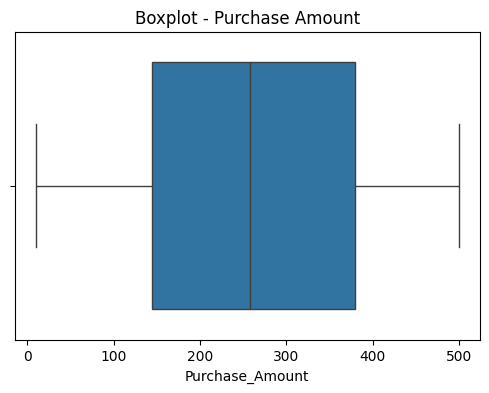

In [437]:
# D. Handling Outliers
# Boxplot for Purchase Amount
plt.figure(figsize=(6, 4))
sns.boxplot(x=sales_df['Purchase_Amount'])
plt.title('Boxplot - Purchase Amount')
plt.show()



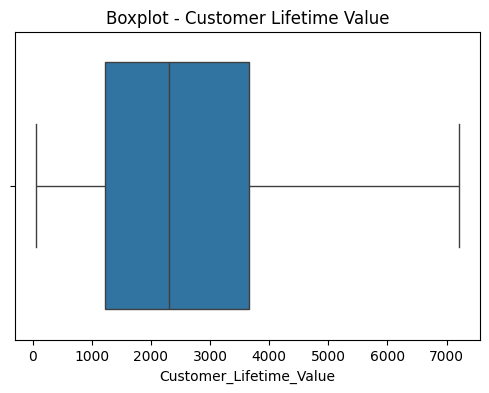

In [438]:
# Boxplot for CLV
plt.figure(figsize=(6, 4))
sns.boxplot(x=sales_df['Customer_Lifetime_Value'])
plt.title('Boxplot - Customer Lifetime Value')
plt.show()


In [439]:
##The boxplot for Purchase Amount shows a relatively symmetric distribution with no extreme outliers.
#The majority of purchase values lie within the interquartile range, indicating stable spending behavior across customers.

In [440]:
# Box plot for CLV: Most customers generate moderate lifetime value, but a small number of customers generate extremely high value — and they matter a LOT.

In [441]:
from scipy.stats import zscore
sales_df['Purchase_Amount_zscore'] = zscore(sales_df['Purchase_Amount'])
sales_df['CLV_zscore'] = zscore(sales_df['Customer_Lifetime_Value'])
purchase_outliers = sales_df[abs(sales_df['Purchase_Amount_zscore']) > 3]
clv_outliers = sales_df[abs(sales_df['CLV_zscore']) > 3]

print("Purchase Amount Outliers:", purchase_outliers.shape[0])
print("CLV Outliers:", clv_outliers.shape[0])


Purchase Amount Outliers: 0
CLV Outliers: 0


In [442]:
# The box plot with no major IQR- based outliers and the fact that Z-Score also has 0 outliers - means no extreme deviations.
# These mean that the data is stable and reliable. Hence no data needs to removed, and all values are retained to preserve genuine customer behaviour.

In [443]:
#E. Feature Engineering has been take care of, since the new columns are present in the excel

In [444]:
##Step 2. Machine Learning Tasks.
#A. 1. K-Means Clustering to segment customers based on total purchase amount, number of orders and loyalty scores.
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


In [445]:
#Creating customer level features to be used for segmentation
customer_features = (
    sales_df.groupby('Customer_ID')
    .agg(
        Total_Purchase_Amount=('Purchase_Amount', 'sum'),
        Number_of_Orders=('Purchase_Amount', 'count'),
        Loyalty_Score=('Loyalty_Score', 'mean')  # or 'max' if your definition prefers
    )
    .reset_index()
)

In [446]:
customer_features[['Customer_ID', 'Total_Purchase_Amount','Number_of_Orders','Loyalty_Score']].head()


,Customer_ID,Total_Purchase_Amount,Number_of_Orders,Loyalty_Score
0,10001,145.014556,2,22.0
1,10004,238.894581,1,48.0
2,10005,453.168418,1,94.0
3,10009,721.487122,3,20.0
4,10011,89.687865,1,90.0


In [447]:
#Creating a copy of customer features and scaling features
X = customer_features[['Total_Purchase_Amount', 'Number_of_Orders', 'Loyalty_Score']].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [448]:
# Elbow method to pick K

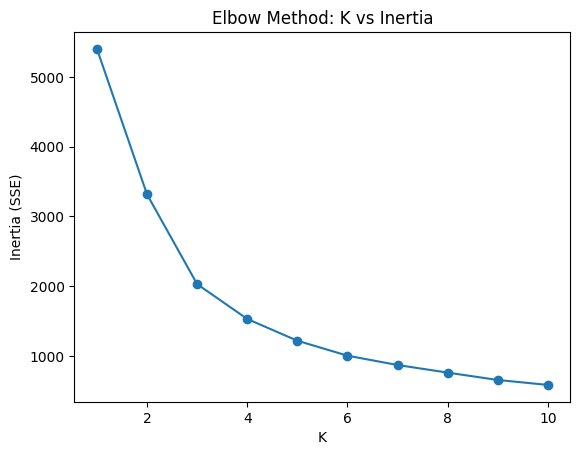

In [449]:
inertias = []
Ks = range(1, 11)

for k in Ks:
    km = KMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow Method: K vs Inertia")
plt.xlabel("K")
plt.ylabel("Inertia (SSE)")
plt.show()


In [450]:
# From this curve, it looks like 3 is the point at which the curve bent
K = 3  # <-- set based on elbow plot

kmeans = KMeans(n_clusters=K, init="k-means++", n_init=10, random_state=42)
customer_features["Customer_Segment_Cluster"] = kmeans.fit_predict(X_scaled)

print("Iterations:", kmeans.n_iter_)
print("Inertia:", kmeans.inertia_)


Iterations: 8
Inertia: 2030.7550009246243


In [451]:
#Cluster profiling
cluster_summary = (
    customer_features.groupby("Customer_Segment_Cluster")[["Total_Purchase_Amount", "Number_of_Orders", "Loyalty_Score"]]
    .mean()
    .sort_values(by="Total_Purchase_Amount", ascending=False)
)

print(cluster_summary)
print("\nCustomers per cluster:")
print(customer_features["Customer_Segment_Cluster"].value_counts())


                          Total_Purchase_Amount  Number_of_Orders  \
Customer_Segment_Cluster                                            
0                                    545.623842          2.129944   
1                                    258.892444          1.000000   
2                                    258.636118          1.000000   

                          Loyalty_Score  
Customer_Segment_Cluster                 
0                             48.945857  
1                             76.391778  
2                             26.526382  

Customers per cluster:
Customer_Segment_Cluster
1    827
2    796
0    177
Name: count, dtype: int64


In [452]:
# Cluster 0 consists of 177 customers who have the highest purchase amount and highest no of average orders but moderate loyalty score
# Cluster 1 consists of 827 customers who have moderate purchase amount and only 1 purchase on average but very high on loyalty score
#Cluster 2 consists of 796 customers, who have moderate purchase, only 1 purchase and lowest loyalty score- these are definitely low value customers

In [453]:
#To visualize the clusters, putting up a scatter plot of the main features Total purchase amount, No of orders and Custome Segment Cluster

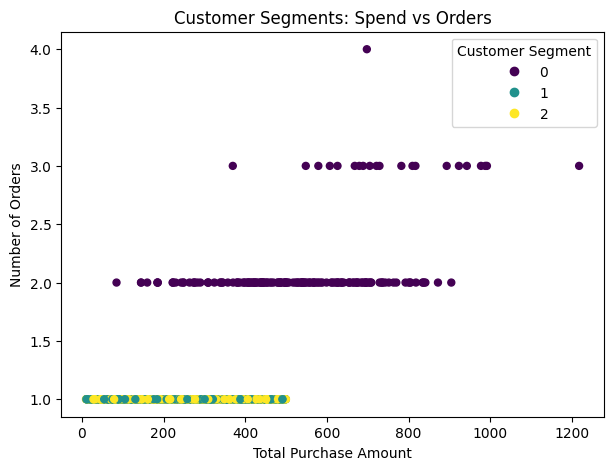

In [454]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
scatter_plot = plt.scatter(
    customer_features['Total_Purchase_Amount'],
    customer_features['Number_of_Orders'],
    c=customer_features['Customer_Segment_Cluster'],
    s=25
)
plt.xlabel('Total Purchase Amount')
plt.ylabel('Number of Orders')
plt.title('Customer Segments: Spend vs Orders')
legend = plt.legend(
    *scatter_plot.legend_elements(),
    title="Customer Segment")
plt.show()

In [455]:
## Insights from Customer Segment Spend vs Others: Except for "0" category all other category customers only have 1 order and the highest purchase amount
# The customer order value for segment "1" and "2" is approx the same


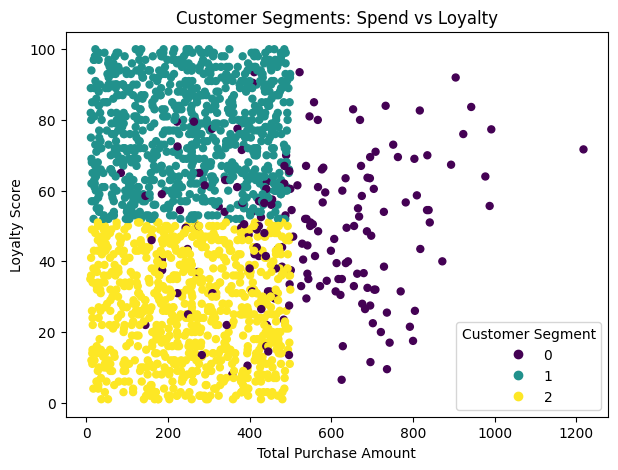

In [456]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

scatter = plt.scatter(
    customer_features['Total_Purchase_Amount'],
    customer_features['Loyalty_Score'],
    c=customer_features['Customer_Segment_Cluster'],
    s=25
)

plt.xlabel('Total Purchase Amount')
plt.ylabel('Loyalty Score')
plt.title('Customer Segments: Spend vs Loyalty')

legend = plt.legend(
    *scatter.legend_elements(),
    title="Customer Segment"
)

plt.show()


In [457]:
# Customers in "0" category have highest purchase amount and highest loyalty score- the highest value customer
# Customers in "1"category have moderate purchase amount but are very loyal- they are occassional but loyal customers
# Customers in "2" category have moderate purchase amount but have low loyalty score- these are the lowest value customers

In [458]:
# What this means for personalisation strategy:
# 0- Premium recommendations, early access, no discounts- high spend and moderate loyalty hence premium recommendations should be given
# 1- Cross-sell, bundles, mild discounts- because of high loyalty score
# 2- Win-back offers, limited promos

# What this means for pricing:
# 0- Minimal discounts, value-based pricing- because they don't seem like price sensitive customers
# 1- Personalised discounts, bundle pricing- to try to increase purchase amount because they are loyal customers
# 2- Aggressive discounts or flash sales- since they are likely to be price sensitive given low loyalty scores


In [459]:
## 2. Predicting Customer Lifetime Value


In [460]:
#Before predicting CLV, we need to fill the 200 remaining values that were left blank.
#Better to impute CLV based on the customer category that we inputed, than generic mean/median

# Merge customer-level aggregated features back into sales_df
sales_df_merged = sales_df.merge(
    customer_features[['Customer_ID', 'Total_Purchase_Amount', 'Number_of_Orders', 'Customer_Segment_Cluster']],
    on='Customer_ID',
    how='left'
)

sales_df_merged['CLV_was_missing'] = sales_df_merged['Customer_Lifetime_Value'].isna()

cluster_clv_mean = (
    sales_df_merged
    .dropna(subset=['Customer_Lifetime_Value'])
    .groupby('Customer_Segment_Cluster')['Customer_Lifetime_Value']
    .mean()
)

sales_df_merged['Customer_Lifetime_Value'] = sales_df_merged['Customer_Lifetime_Value'].fillna(
    sales_df_merged['Customer_Segment_Cluster'].map(cluster_clv_mean)
)

sales_df_merged['Customer_Lifetime_Value'] = sales_df_merged['Customer_Lifetime_Value'].fillna(
    sales_df_merged['Customer_Lifetime_Value'].mean()
)
sales_df_merged.loc[sales_df_merged['CLV_was_missing'],
                    ['Customer_ID', 'Customer_Segment_Cluster', 'Customer_Lifetime_Value']].head(20)


,Customer_ID,Customer_Segment_Cluster,Customer_Lifetime_Value
44,12612,2,2586.728702
47,16235,2,2586.728702
49,17099,0,2566.193813
61,19692,0,2566.193813
80,16331,2,2586.728702
96,10391,2,2586.728702
107,12731,1,2548.197976
118,16938,0,2566.193813
123,17721,1,2548.197976
147,13627,0,2566.193813


In [461]:
# for creating linear regression, define target and features:
# Target
y = sales_df_merged['Customer_Lifetime_Value']

# Features
X = sales_df_merged[
    [
        'Age',
        'Total_Purchase_Amount',   # past purchases
        'Number_of_Orders',
        'Discount_Applied',        # Yes / No
        'Payment_Method',          # categorical
        'Loyalty_Score'
    ]
].copy()

In [462]:
#Encode categorical variables
X['Discount_Applied'] = X['Discount_Applied'].map({'Yes': 1, 'No': 0})
X = pd.get_dummies(X, columns=['Payment_Method'], drop_first=True)


In [463]:
#Final sanity checks
print("Missing values in X:\n", X.isna().sum())
print("Missing values in y:", y.isna().sum())


Missing values in X:
 Age                           0
Total_Purchase_Amount         0
Number_of_Orders              0
Discount_Applied              0
Loyalty_Score                 0
Payment_Method_Cash           0
Payment_Method_Credit Card    0
Payment_Method_PayPal         0
dtype: int64
Missing values in y: 0


In [464]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [465]:
#Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [466]:
#Train linear regression model
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


LinearRegression()

In [467]:
#Make predictions
y_pred = lr_model.predict(X_test_scaled)
# Save Linear Regression pipeline objects
clv_scaler = scaler
clv_feature_cols = X_train.columns


In [468]:
#Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R² Score:", r2_score(y_test, y_pred))


MAE: 697.5598123468793
RMSE: 893.2682865409861
R² Score: 0.6071096195449668


In [469]:
# the above means, MAE the CLV prediction is off by ~$700.
# RMSE>MAE means that large prediction errors exist, this could be because is CLV is right skewed.
# R2=0.61- this means that 61% of the variability can be explained with age, past purchases, discount usage, payment method, loyalty score.

In [470]:
# In order to make performance better, lets try with a log transformed CLV instead of the previous scaler etc used


In [471]:
# Create log transformed target:
y_log = np.log1p(sales_df_merged['Customer_Lifetime_Value'])


In [472]:
#Train test split (log CLV)
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

In [473]:
# Train linear regression on log-CLV
lr_log_model = LinearRegression()
lr_log_model.fit(X_train_scaled, y_train_log)

LinearRegression()

In [474]:
# Predict log-CLV
y_pred_log = lr_log_model.predict(X_test_scaled)

# Convert back to original CLV scale
y_pred_clv = np.expm1(y_pred_log)
y_test_clv = np.expm1(y_test_log)


In [475]:
# Evaluate log model
print("MAE (log model):", mean_absolute_error(y_test_clv, y_pred_clv))
print("RMSE (log model):", np.sqrt(mean_squared_error(y_test_clv, y_pred_clv)))
print("R² (log model):", r2_score(y_test_clv, y_pred_clv))


MAE (log model): 771.392340840317
RMSE (log model): 1019.0317938643612
R² (log model): 0.4886914760099744


In [476]:
# Overall MAE, RMSE and R square is worse off for the log model than the original model. Hence better to stick with the previous original model.

In [477]:
## Logistic Regression Model for churn prediction

In [478]:
# Would look to create logistic regression model for churn prediction based on behaviour signals:
# These behaviour signals I would choose would be : Loyalty score, No of orders (to show frequency), Recency days-how many days since last purchase  and Customer Segment Cluster.
# In order to build a logistic regression model, we need a churn label in the original data. We need to create it using the following assumption:
#Assumption for churn label:  Customers who have not purchased anything in the last 60 days are churned customers.

In [489]:
# Snapshot date = last date in dataset
snapshot_date = sales_df['Purchase_Date'].max()

# Customer-level recency
churn_df = (
    sales_df.groupby('Customer_ID')
    .agg(
        Last_Purchase_Date=('Purchase_Date', 'max'),
        Number_of_Orders=('Purchase_Date', 'count'),
        Loyalty_Score=('Loyalty_Score', 'mean')
    )
    .reset_index()
)

churn_df['Recency_Days'] = (snapshot_date - churn_df['Last_Purchase_Date']).dt.days
CHURN_DAYS = 60  # common and defensible

churn_df['Churn'] = (churn_df['Recency_Days'] > CHURN_DAYS).astype(int)
churn_labels = churn_df[['Customer_ID', 'Churn', 'Recency_Days']]


print(churn_df['Churn'].value_counts())



Churn
0    1348
1     452
Name: count, dtype: int64


In [480]:
# As seen above, churn label of 1 has been given to 452 customers who have not made a purchase since last 60 days as per the assumption taken
# Logistic regression model should be based on behaviour indicators like loyalty score, no of orders, recency days and customer_segment_customers as made with KNN.

In [481]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, precision_recall_curve)

In [493]:
# Ensure churn_df has 'Customer_Segment_Cluster' by mapping from customer_features
seg_cluster_mapping_series = customer_features.set_index('Customer_ID')['Customer_Segment_Cluster']
churn_df['Customer_Segment_Cluster'] = churn_df['Customer_ID'].map(seg_cluster_mapping_series)

# Now define X including the new 'Customer_Segment_Cluster' column
X = churn_df[
    [
        'Loyalty_Score',
        'Number_of_Orders',
        'Recency_Days',
        'Customer_Segment_Cluster'
    ]
].copy()

X = pd.get_dummies(X, columns=['Customer_Segment_Cluster'], drop_first=True)

y = churn_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    random_state=42
)
log_reg.fit(X_train_scaled, y_train)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Save churn pipeline objects
churn_scaler = scaler
churn_feature_cols = X_train.columns

print(classification_report(y_test, log_reg.predict(X_test_scaled)))
print("ROC-AUC:", roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1]))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       270
           1       0.93      1.00      0.96        90

    accuracy                           0.98       360
   macro avg       0.96      0.99      0.97       360
weighted avg       0.98      0.98      0.98       360

ROC-AUC: 0.9995061728395063


In [483]:
#Meaning of the above
# Recall of 0.79 for 1 means that in case of customers who actually churned the model was able to predict correctly in 79% of the cases
# Precision of 0.26 means that only 26% of the cases are being predicted correctly
# So, the model is tending to give more false positives- so claims that someone is going to churn when they are not churning

In [484]:
sales_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer_ID                 2000 non-null   int64         
 1   Customer_Name               1900 non-null   object        
 2   Age                         2000 non-null   int64         
 3   Gender                      2000 non-null   object        
 4   Location                    2000 non-null   object        
 5   Product_Category            2000 non-null   object        
 6   Product_ID                  2000 non-null   int64         
 7   Purchase_Date               2000 non-null   datetime64[ns]
 8   Purchase_Amount             2000 non-null   float64       
 9   Payment_Method              2000 non-null   object        
 10  Rating                      2000 non-null   int64         
 11  Feedback_Comments           1099 non-null   object      

In [485]:
  # In order to download the entire sales_df with new features like CLV prediction, churn prediction, running the models and adding them to the original excel


In [490]:
X_clv_all = sales_df_merged[
    [
        'Age',
        'Total_Purchase_Amount',
        'Number_of_Orders',
        'Discount_Applied',
        'Payment_Method',
        'Loyalty_Score'
    ]
].copy()

# Binary encode Discount_Applied
X_clv_all['Discount_Applied'] = X_clv_all['Discount_Applied'].map({'Yes': 1, 'No': 0})

# One-hot encode Payment_Method
X_clv_all = pd.get_dummies(X_clv_all, columns=['Payment_Method'], drop_first=True)

X_clv_all = X_clv_all.reindex(columns=clv_feature_cols, fill_value=0)
X_clv_all_scaled = clv_scaler.transform(X_clv_all)
sales_df_merged['CLV_Predicted'] = lr_model.predict(X_clv_all_scaled)
sales_df_merged['CLV_Error'] = (
    sales_df_merged['Customer_Lifetime_Value'] - sales_df_merged['CLV_Predicted'])

sales_df_merged[
    ['Customer_ID', 'Customer_Lifetime_Value', 'CLV_Predicted','CLV_Error']
].head(10)

,Customer_ID,Customer_Lifetime_Value,CLV_Predicted,CLV_Error
0,17270,3673.712747,4473.369671,-799.656924
1,10860,2103.060388,1597.196453,505.863935
2,15390,899.115059,1017.063559,-117.948500
3,15191,2591.137716,2392.725887,198.411829
4,15734,548.620397,826.972231,-278.351834
5,16265,2727.555899,4386.387768,-1658.831869
6,10466,3076.554423,2838.634032,237.920391
7,14426,3269.745729,2888.036577,381.709152
8,15578,4319.156456,3167.690497,1151.465959
9,18322,3428.350802,2552.668988,875.681814


In [491]:
sales_df_merged = sales_df_merged.merge(
    churn_labels,
    on='Customer_ID',
    how='left'
)


In [494]:
print(sales_df_merged['Churn_y'].value_counts())

# Ensure no missing churn labels
print(sales_df_merged['Churn_y'].isna().sum())

Churn_y
0    1534
1     466
Name: count, dtype: int64
0


In [495]:
# Create churn feature matrix in the same way as training
X_churn_all = churn_df[
    ['Loyalty_Score', 'Number_of_Orders', 'Recency_Days', 'Customer_Segment_Cluster']
].copy()

X_churn_all = pd.get_dummies(X_churn_all, columns=['Customer_Segment_Cluster'], drop_first=True)

# Align columns to training
X_churn_all = X_churn_all.reindex(columns=churn_feature_cols, fill_value=0)

# Scale and predict churn probability
X_churn_all_scaled = churn_scaler.transform(X_churn_all)

churn_df['Churn_Probability'] = log_reg.predict_proba(X_churn_all_scaled)[:, 1]
churn_df['Churn_Predicted'] = (churn_df['Churn_Probability'] >= 0.5).astype(int)  # default threshold

# Keep only what you want to add to sales_df_merged
churn_out = churn_df[['Customer_ID', 'Churn', 'Churn_Probability', 'Churn_Predicted']].copy()

# Merge into transaction-level dataset
sales_df_merged = sales_df_merged.merge(churn_out, on='Customer_ID', how='left')

In [496]:
sales_df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer_ID                 2000 non-null   int64         
 1   Customer_Name               1900 non-null   object        
 2   Age                         2000 non-null   int64         
 3   Gender                      2000 non-null   object        
 4   Location                    2000 non-null   object        
 5   Product_Category            2000 non-null   object        
 6   Product_ID                  2000 non-null   int64         
 7   Purchase_Date               2000 non-null   datetime64[ns]
 8   Purchase_Amount             2000 non-null   float64       
 9   Payment_Method              2000 non-null   object        
 10  Rating                      2000 non-null   int64         
 11  Feedback_Comments           1099 non-null   object      

In [497]:
sales_df_merged.to_csv('sales_df_merged.csv', index=False)


In [498]:
from google.colab import files
files.download('sales_df_merged.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

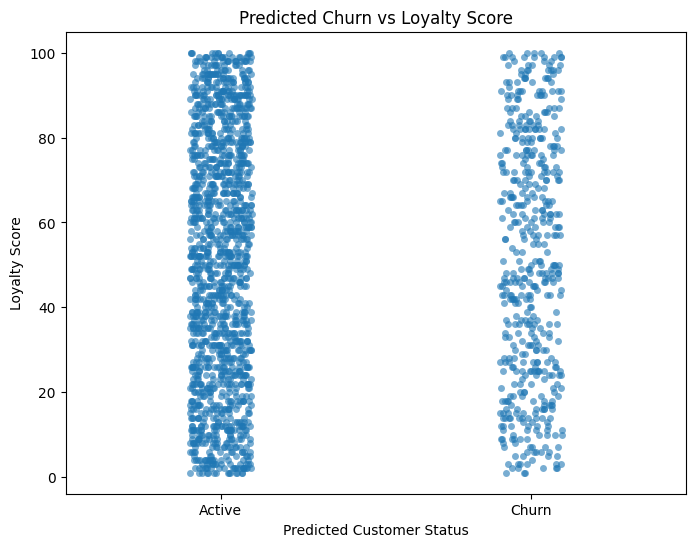

In [505]:
#Visualise predicted churn vs loyalty score

plt.figure(figsize=(8,6))
sns.stripplot(
    data=sales_df_merged,
    x='Churn_Predicted_y',
    y='Loyalty_Score',
    jitter=True,
    alpha=0.6
)

plt.xticks([0, 1], ['Active', 'Churn'])
plt.xlabel('Predicted Customer Status')
plt.ylabel('Loyalty Score')
plt.title('Predicted Churn vs Loyalty Score')
plt.show()

In [507]:
# As we can see in above visualisation for the active customers, the loyalty score is higher (as seen by denser no of points towards the higher part of Y axis)
#Hence customers predicted to churn generally have lower loyalty scores.

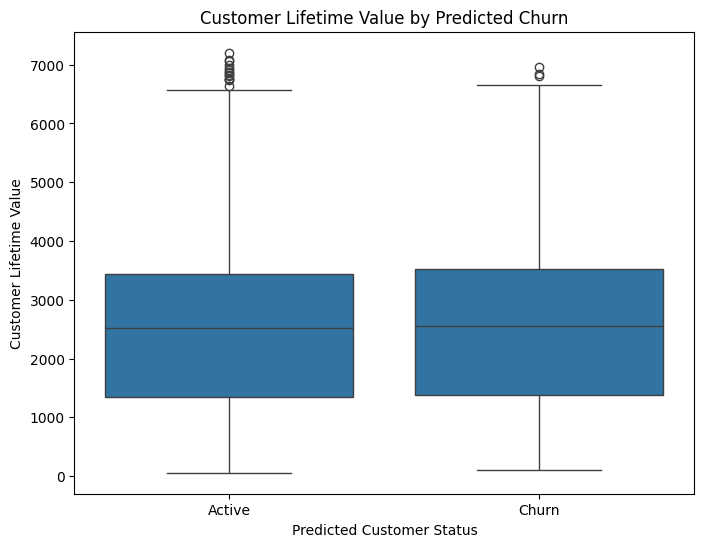

In [508]:
#Visualise churn_prediction vs customer_lifetime value

plt.figure(figsize=(8,6))
sns.boxplot(
    data=sales_df_merged,
    x='Churn_Predicted_y',
    y='Customer_Lifetime_Value'
)

plt.xticks([0, 1], ['Active', 'Churn'])
plt.xlabel('Predicted Customer Status')
plt.ylabel('Customer Lifetime Value')
plt.title('Customer Lifetime Value by Predicted Churn')
plt.show()


In [509]:
# The above visualisation shows us that Median CLV is very similar for both active and churn customers. This means churn is not limited to low value customers.
# There are a few high value customers who are at risk of churning- hence very important to identify them and target them to retain them

In [510]:
cluster0_df = sales_df_merged[sales_df_merged['Customer_Segment_Cluster'] == 0]


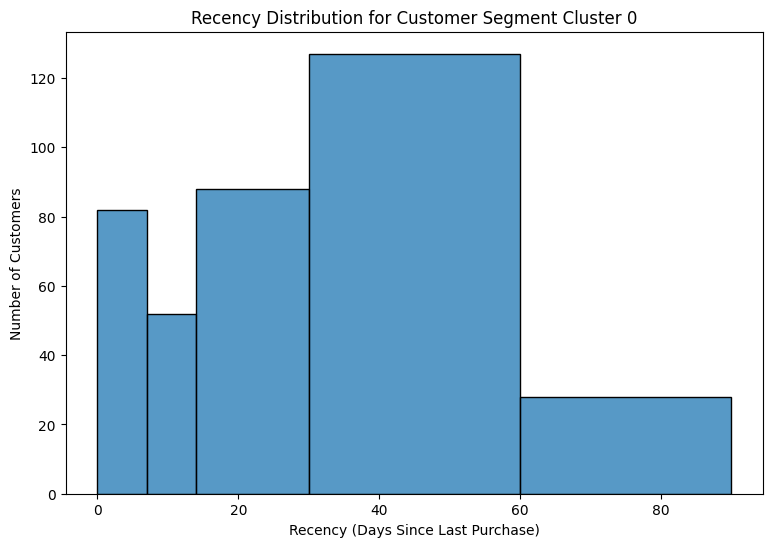

In [511]:
plt.figure(figsize=(9,6))
sns.histplot(
    cluster0_df['Recency_Days'],
    bins=[0, 7, 14, 30, 60, 90],
    kde=False
)

plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Number of Customers')
plt.title('Recency Distribution for Customer Segment Cluster 0')
plt.show()

SUMMARY:
1) Identifying high-value customers for targeted marketing.
- As per what we saw in this data, its important to target the high value category "0" customers and also check their recency days- need to ensure we target those individuals who have not purchased anything since last 60 days to continue to retain them.

2) Predicting Customer Lifetime Value (CLV) to improve revenue forecasting.
Based on the linear regression model given here- bases an individual shoppers age, past purchases, discount usage, payment method and loyalty score we can predict future revenue based on current set of customers.

3) Understanding customer churn risks and improving retention strategies.
Using churn prediction logistics regression, we can target the high value customers who haven't purchased since 60 days to ensure we retain them. Since the logistics regression model tends to give false positives (predicts when its not actually churning)- necessary to restrict retention to only high value customers and maybe even the loyal but lower CLV customers.

4) Grouping customers into actionable segments based on behavior patterns:
As seen in KNN,
0- High value VIP customers
1- Loyal but lower value customers
2- Not loyal and lower value customers- more occassional.
